In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from netCDF4 import Dataset
from tqdm import tqdm
from scipy.signal import fftconvolve

from obspy.geodetics.base import locations2degrees
from obspy.taup import TauPyModel
from obspy.core.trace import Stats, Trace, UTCDateTime

# Read event and station info

In [2]:
# simulation name
simulation_name = 'prem_5s__no_3d_mantle_crust__no_hetero'
input_dir = Path('simulations/' + simulation_name + '/input')

# stations
s_data = np.loadtxt(f'{input_dir}/STATIONS', dtype=str)
s_name = s_data[:, 0]
s_network = s_data[:, 1]
s_lat = s_data[:, 2].astype(float)
s_lon = s_data[:, 3].astype(float)
s_dep = s_data[:, 5].astype(float)
s_lon[s_lon < 0] += 360.

# earthquake
e_data = np.loadtxt(f'{input_dir}/CMTSOLUTION', skiprows=1, dtype=str, delimiter=':')
e_lat = float(e_data[3, 1])
e_lon = float(e_data[4, 1])
e_dep = float(e_data[5, 1])
if e_lon < 0:
    e_lon += 360.

# Compute distances and travel times


In [3]:
distances = []
needed_phases = {'P': ['P', 'Pdiff'], 'PcP': ['PcP'], 'pP': ['pP', 'pPdiff']}
all_needed = []
for phases in needed_phases.values():
    all_needed += phases
travel_times = {key: [] for key in needed_phases.keys()}

taup_model = TauPyModel(model="prem")
for lat, lon in tqdm(zip(s_lat, s_lon), total=len(s_lat)):
    # taup ray tracing
    distance = locations2degrees(lat, lon, e_lat, e_lon)
    distances.append(distance)
    arrivals = taup_model.get_travel_times(source_depth_in_km=e_dep,
                                           distance_in_degree=distance,
                                           phase_list=all_needed)
    for phase in needed_phases.keys():
        # use inf if no such phase
        t_res = np.inf
        for arr in arrivals:
            if arr.name in needed_phases[phase]:
                t_res = arr.time
        travel_times[phase].append(t_res)

distances = np.array(distances)
for key in needed_phases.keys():
    travel_times[key] = np.array(travel_times[key])

100%|██████████| 1834/1834 [00:25<00:00, 73.09it/s]


# Read, process and plot seismograms

In [4]:
def read_process_seis(output_dir, mesh_period, channel=2, sampling_rate=None, 
                      gaussian_noise_level=0.):
    seis = []
    with Dataset(output_dir / 'stations/axisem3d_synthetics.nc', 'r') as nc:
        # header
        times = nc.variables['time_points'][:]
        stats = Stats()
        stats.npts = len(times)
        stats.delta = times[1] - times[0]
        stats.starttime = UTCDateTime(times[0])
        
        # source-time function
        hdur = mesh_period / 1.5
        decay = 1.628
        nstf = int(np.ceil(2.5 * hdur / stats.delta))
        tstf = np.arange(-nstf, nstf + 1) * stats.delta
        stf = np.exp(-np.power((decay / hdur * tstf), 2.)) * decay / (hdur * np.sqrt(np.pi))
        stf /= stf.sum()
        
        # filter window
        tmin = mesh_period * 0.8
        tmax = mesh_period * 20.

        for name, network in tqdm(zip(s_name, s_network), total=len(s_lat)):
            # read
            data = nc.variables[f'{network}.{name}.RTZ'][:, channel]
            # convolve with stf
            data = fftconvolve(data, stf, mode='same')
            # noise
            noise = np.random.normal(scale=np.std(data) * gaussian_noise_level, size=data.shape)
            # trace
            trace = Trace(data + noise, header=stats)
            # filter
            trace = trace.filter('bandpass', freqmin=1 / tmax, freqmax=1 / tmin)
            # resample and trim
            if sampling_rate is None:
                sampling_rate = stats.sampling_rate
            trace.interpolate(sampling_rate, starttime=0)
            seis.append(trace)
    return seis

In [5]:
def plot_record_section(seis_plot, seis_ref=None, zoom_factor=3e3, 
                        start_index=0, end_index=300, align='P', title=''):
    # plot a subset of stations
    loc = slice(start_index, end_index)
    plt.figure(dpi=200, figsize=(4, 6))
    for i, (distance, seis, align_time) in enumerate(zip(distances[loc], seis_plot[loc], 
                                                     travel_times[align][loc])):
        if seis_ref is None:
            plt.plot(seis.times() - align_time, 
                     seis.data * zoom_factor + distance, c='k', lw=.4)
        else:
            min_len = min(len(seis.data), len(seis_ref[loc][i].data))
            data_plot = seis.data[:min_len] - seis_ref[loc][i].data[:min_len]
            plt.plot((seis.times() - align_time)[:min_len], 
                     data_plot * zoom_factor + distance, c='k', lw=.4)

    # plot travel times
    idx_sort = np.argsort(distances)
    for phase in travel_times.keys():
        t_plot = travel_times[phase][idx_sort] - travel_times[align][idx_sort]
        plt.plot(t_plot, distances[idx_sort], lw=1, c='b')
        plt.text(t_plot[0], distances[idx_sort][0], 
                 phase, ha='center', va='top', c='b', rotation=90)
    plt.xlim(-50, 200)
    plt.xlabel('Time after P-arrival (sec)')
    plt.ylabel('Epicentral distance (deg)')
    plt.title(title, fontsize=10)
    plt.show()

In [6]:
simulation_name_1d = 'prem_5s__no_3d_mantle_crust__no_hetero'
simulation_name_3d = 'prem_5s__no_3d_mantle_crust__hetero_fuji_pacific_usarray'
output_dir_1d = Path('results/' + simulation_name_1d + '/output')
output_dir_3d = Path('results/' + simulation_name_3d + '/output')

In [7]:
# read seismograms
seis_1d = read_process_seis(output_dir_1d, mesh_period=5)
seis_3d = read_process_seis(output_dir_3d, mesh_period=5)

100%|██████████| 1834/1834 [00:12<00:00, 145.19it/s]


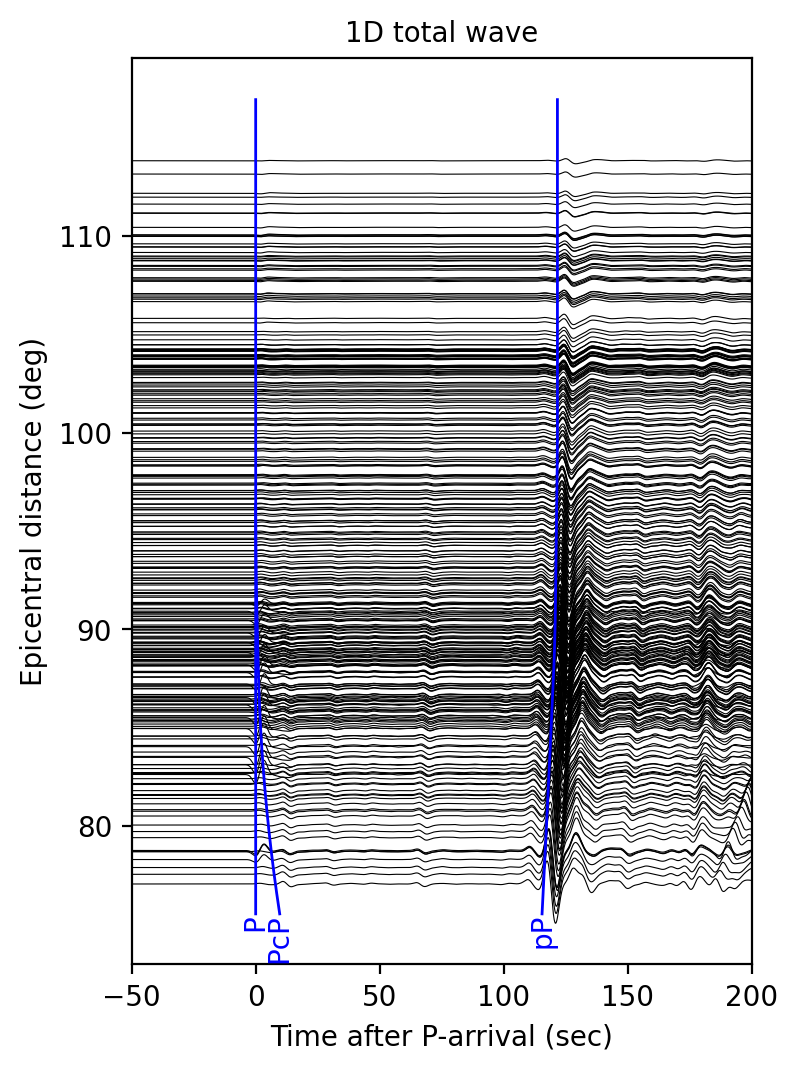

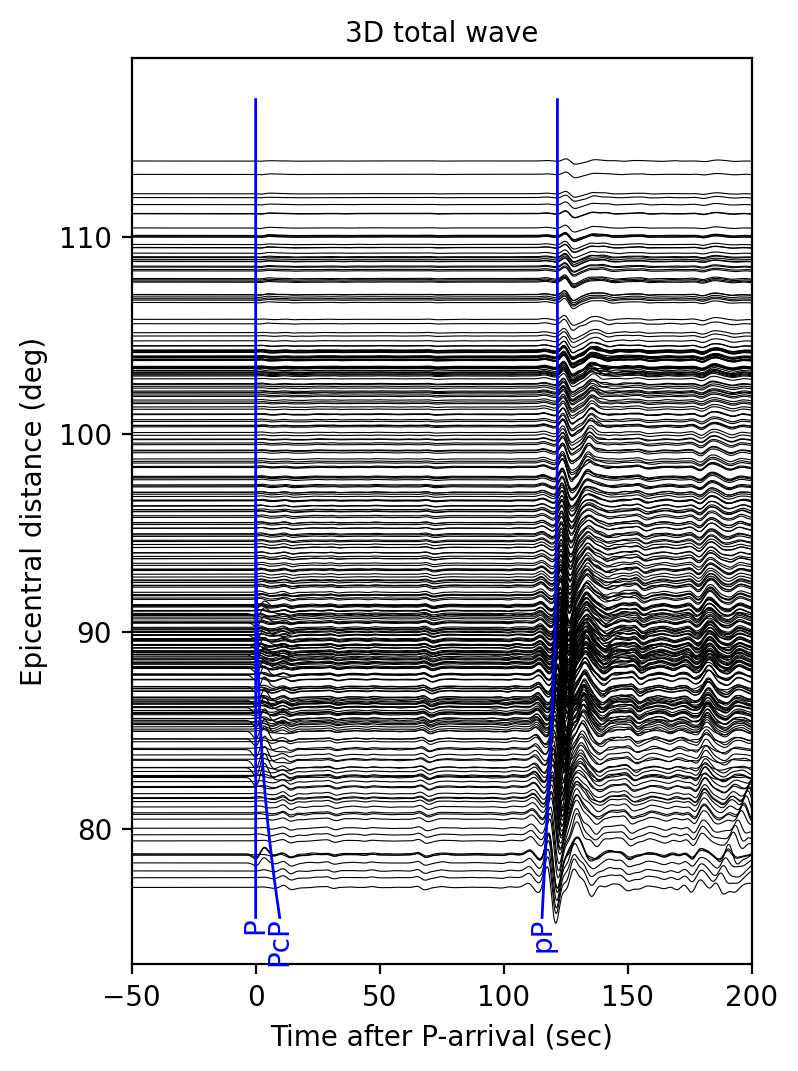

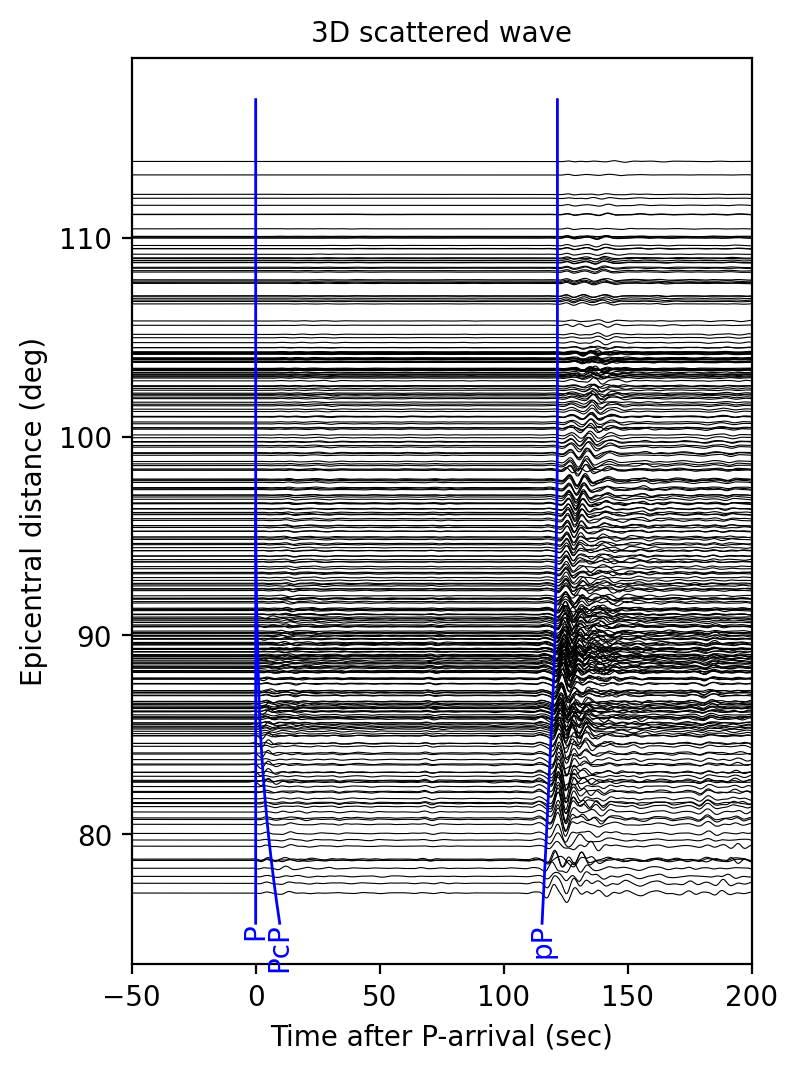

In [8]:
# plot seismograms
plot_record_section(seis_1d, title='1D total wave')
plot_record_section(seis_3d, title='3D total wave')
plot_record_section(seis_3d, seis_ref=seis_1d, title='3D scattered wave', zoom_factor=6e3)

# Add Gaussian noise

Use `gaussian_noise_level` in `read_process_seis()` to add noise to synthetic data, where `gaussian_noise_level` specifies the ratio `std(noise) / std(data)`.

100%|██████████| 1834/1834 [00:11<00:00, 157.90it/s]


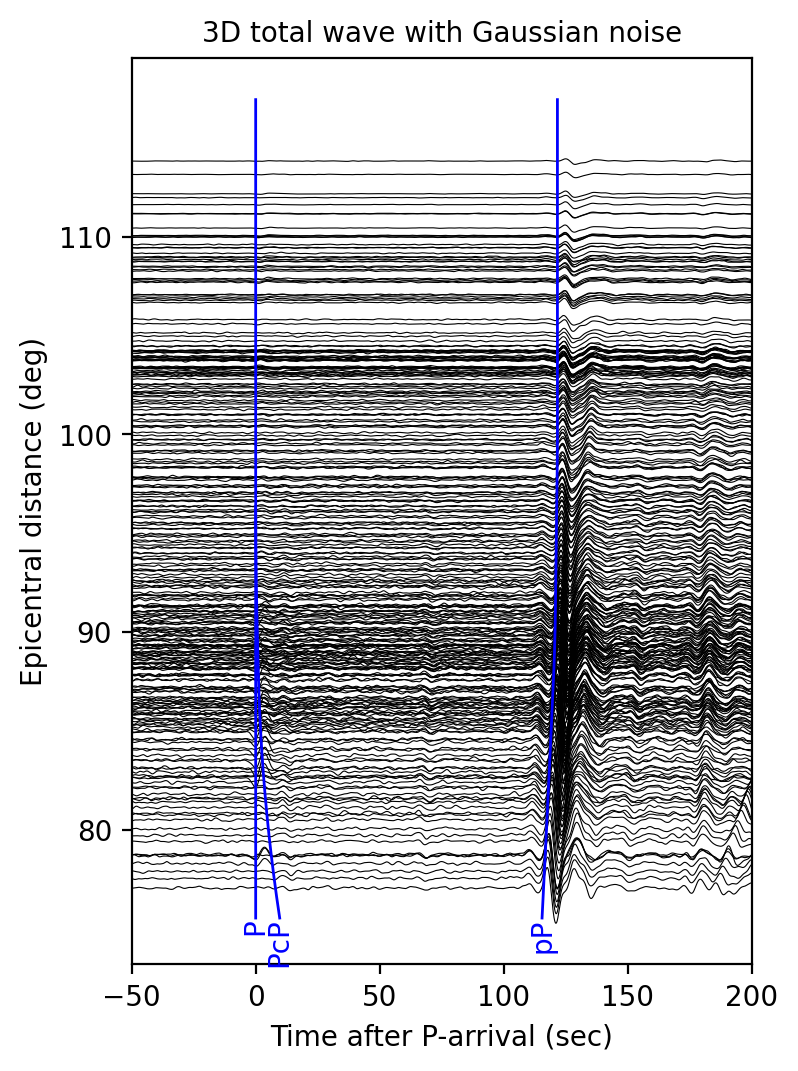

In [9]:
seis_3d_noise = read_process_seis(output_dir_3d, mesh_period=5, 
                                  gaussian_noise_level=2.)
plot_record_section(seis_3d_noise, title='3D total wave with Gaussian noise')